In [48]:
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from copy import copy
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# Add the 'code' directory to sys.path
project_path = Path(
    '/home/ec2-user/SageMaker/david/tdm-sentiment/'
)
data_path = project_path / 'data/'
data_sample = Path('/home/ec2-user/SageMaker/data/')
dataset_name = 'StartupSentiment' #TODO  # 'USATodayDavid' ChicagoTribune' 'Newyork20042023' TheWashingtonPostDavid, LosAngelesTimesDavid, StartupSentiment
folder_path = data_path / 'results/' / dataset_name #TODO

sys.path.append(str(project_path / 'code'))
from salience_index.salience_index import SalienceScorer

In [50]:
def get_all_csv_files(folder_path):
    # Use Path to find all CSV files in the folder
    csv_files = list(Path(folder_path).glob('*.csv'))
    return csv_files



def concat_csv_files(folder_path):
    # Get a list of all CSV files in the folder
    csv_files = get_all_csv_files(folder_path)
    
    # Initialize an empty list to store DataFrames
    df_list = []
    
    # Loop through the list of CSV files
    for file in csv_files:
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Append the DataFrame to the list
        df_list.append(df)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

    

def label_sentiment(sentiment_score):
    """
    Labels sentiment as 'positive', 'negative', or 'neutral' based on the sentiment score.
    
    Args:
        sentiment_score (float): The sentiment score ranging from -1 to 1.
        
    Returns:
        str: The sentiment label ('positive', 'negative', or 'neutral').
    """
    if sentiment_score > 0.5:
        return 'positive'
    elif sentiment_score < -0.5:
        return 'negative'
    else:
        return 'neutral'
 

# Define a function to compute salience score
def compute_salience(row):
    try:
        return scorer.get_salience_score(row['Date'], row['Page'], row['WordCount'], row['Publisher'])
    except Exception:
        return None

    
def mean_sentiment_by_quarter(df):
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract year and quarter from the 'Date' column
    df['Year'] = df['Date'].dt.year
    df = df[df['Year'] > 1989]
    df['Quarter'] = df['Date'].dt.to_period('Q')
    
    # Group by 'Publisher' and 'Quarter' and calculate the mean sentiment for bert and adjusted sentiment
    result = df.groupby(['Quarter'])[['bert_sentiment']].mean().reset_index()
    
    return result

In [51]:
# Combine CSV files from all files
combined_df = concat_csv_files(folder_path)

# Drop duplicate rows based on the 'GOID' column
combined_df = combined_df.drop_duplicates(subset=['GOID'])


combined_df = combined_df[combined_df[['bert_sentiment']].notna().all(axis=1)]
# Initialize the scorer
scorer = SalienceScorer()

# Normalizing 'bert_sentiment' and 'adjusted_sentiment'
#combined_df['bert_sentiment'] = (
#    (combined_df['bert_sentiment'] - combined_df['bert_sentiment'].mean()) / combined_df['bert_sentiment'].std()
#)

combined_df['bert_sentiment_label'] = combined_df['bert_sentiment'].apply(label_sentiment)

In [52]:
combined_df.head()# shape#.head() #

,WordCount,GOID,Publisher,Date,Section,Type,Tags,Page,is_economic,bert_sentiment,bert_sentiment_label
1,626.0,2.932657e+08,atlanta journal the atlanta constitution (pre-...,1996-10-21,foreign news,news,NaN,a.05,NaN,-0.167311,neutral
2,824.0,1.869989e+09,jerusalem post,2017-02-14,opinion,commentary,population,13,NaN,0.521106,positive
3,1720.0,4.320631e+08,new york times,2002-04-04,g,news,inventors,g.1,NaN,0.170471,neutral
4,2368.0,8.751934e+08,jerusalem post,2011-06-17,features,news,secularism,18,NaN,0.309207,neutral
5,1124.0,2.385167e+09,indian express,2020-04-02,NaN,news,chief executive officers,NaN,NaN,-0.055893,neutral


### mean sentiment by quarter

In [53]:
df = mean_sentiment_by_quarter(combined_df)

/tmp/ipykernel_15890/3540858183.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quarter'] = df['Date'].dt.to_period('Q')


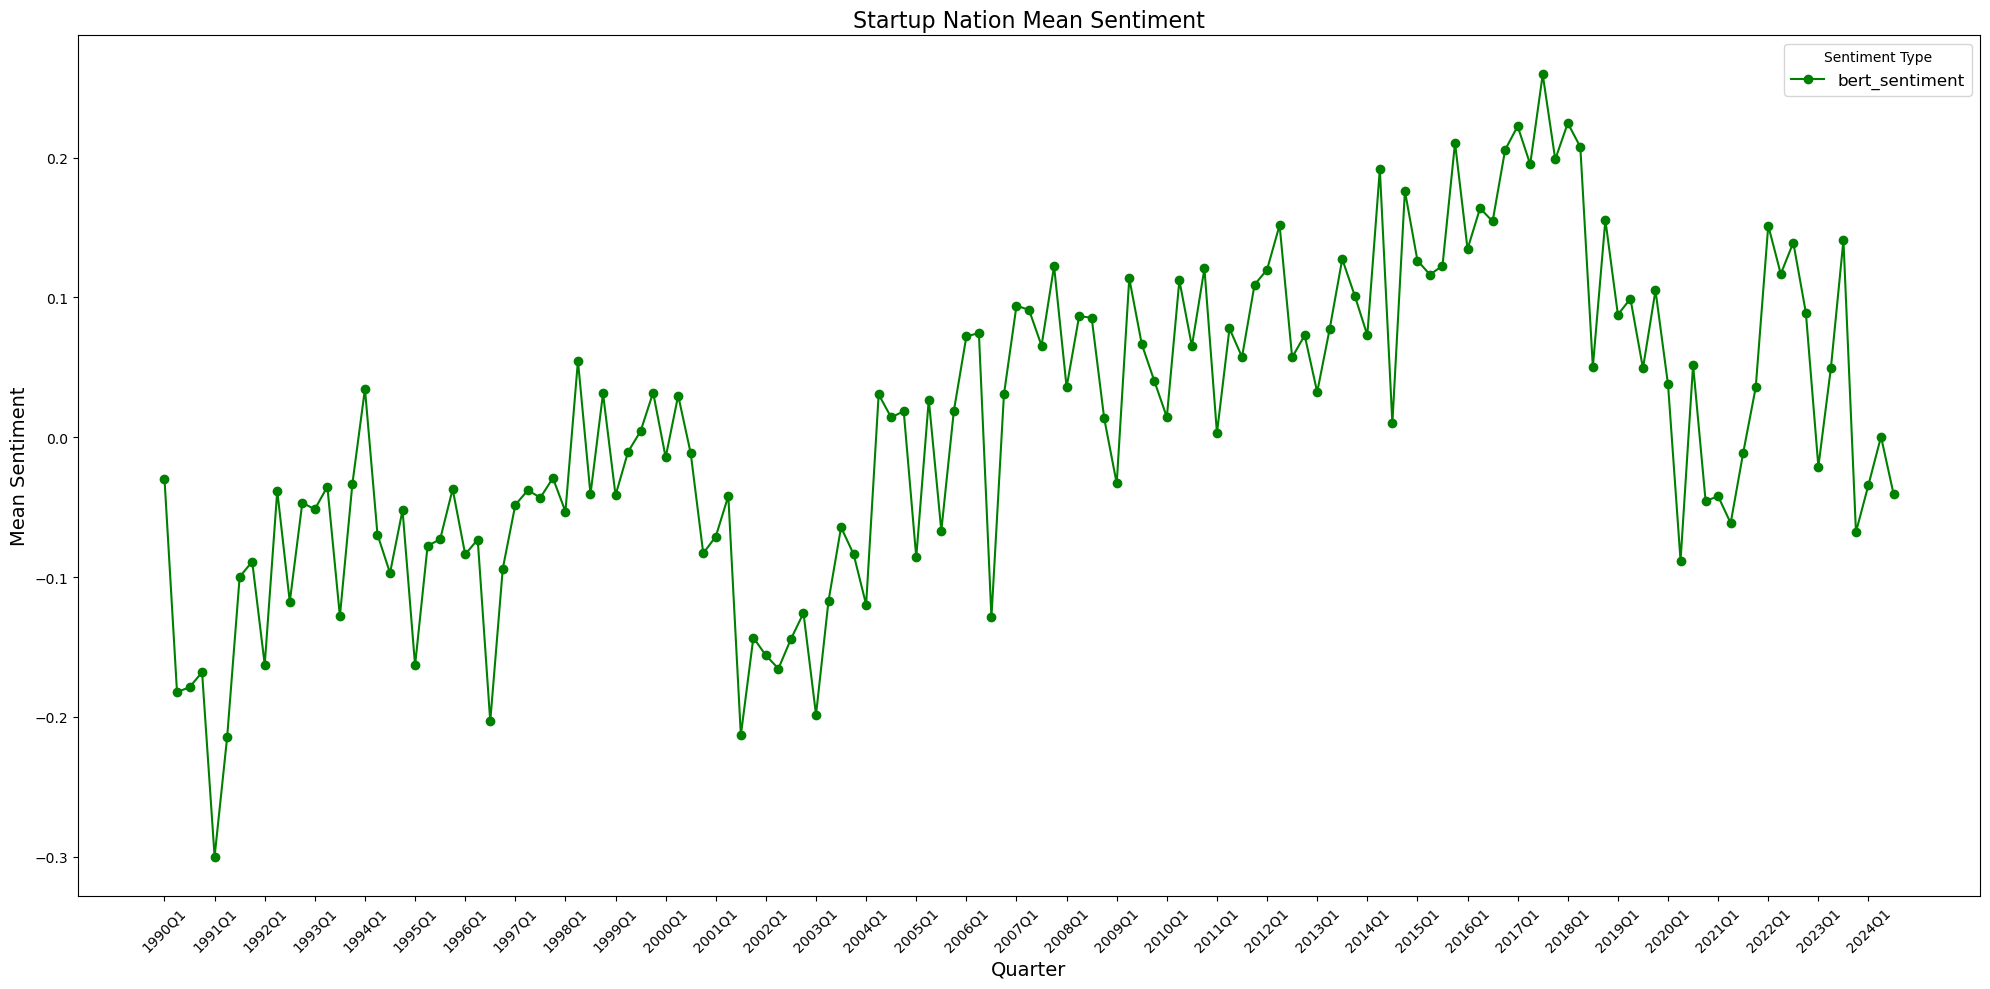

In [54]:
# Ensure the 'Quarter' column is treated as a string
df['Quarter'] = df['Quarter'].astype(str)

# Set the size of the plot
plt.figure(figsize=(20, 10))

# Plot the data using matplotlib
plt.plot(df['Quarter'], df['bert_sentiment'], marker="o", label='bert_sentiment', color='green')

# Customize the plot
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Mean Sentiment', fontsize=14)
plt.title(f'Startup Nation Mean Sentiment', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Display only every nth label on the x-axis
plt.gca().set_xticks(plt.gca().get_xticks()[::4])  # Change '4' to a different number if needed

# Add legend
plt.legend(title='Sentiment Type', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

In [57]:
# Extract year and quarter from the 'Date' column

combined_df['Year'] = combined_df['Date'].dt.year
combined_df = combined_df[combined_df['Year'] > 1989]
# Group by 'Publisher' and 'Quarter' and calculate the mean sentiment
result = combined_df.groupby(['Year'])[['bert_sentiment']].mean().reset_index()
result.head()

,Year,bert_sentiment
0,1990,-0.147023
1,1991,-0.227513
2,1992,-0.091607
3,1993,-0.060148
4,1994,-0.048692


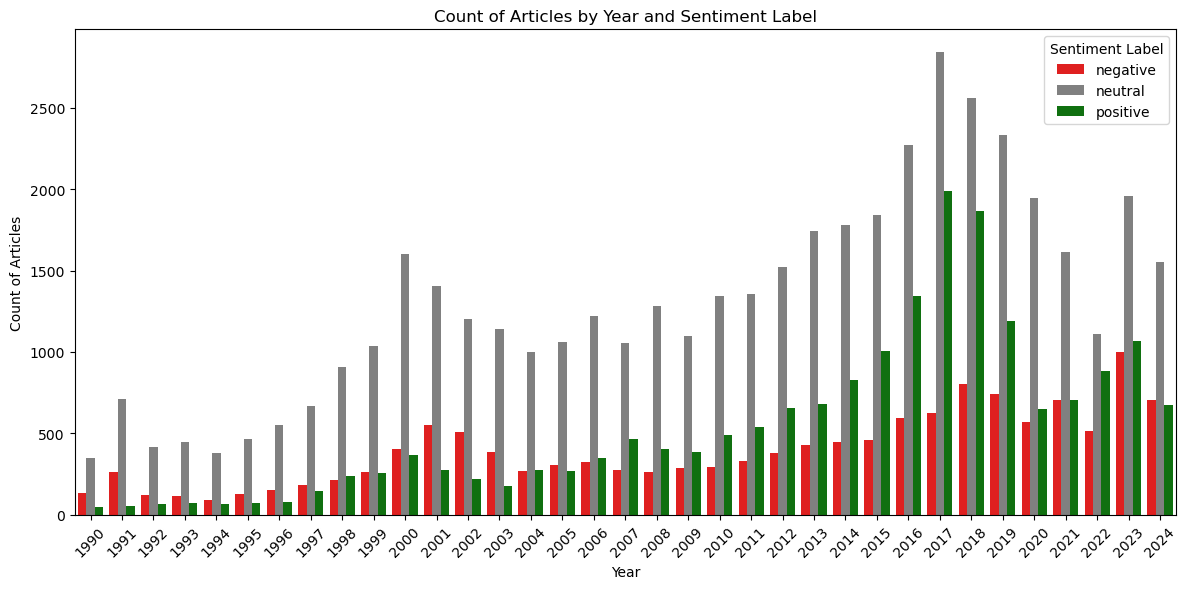

In [58]:
# Group by Year and Sentiment Label, counting occurrences
bert_sentiment_label = combined_df.groupby(['Year', 'bert_sentiment_label']).size().reset_index(name='Count')

# Rename 'bert_sentiment_label' to 'label' for simplicity
bert_sentiment_label.rename(columns={'bert_sentiment_label': 'label'}, inplace=True)

# Define a custom color palette for sentiment labels
custom_palette = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}

# Create a single bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=bert_sentiment_label,
    x='Year',
    y='Count',
    hue='label',
    palette=custom_palette
)

# Customize the plot
plt.title('Count of Articles by Year and Sentiment Label')
plt.xlabel('Year')
plt.ylabel('Count of Articles')
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Sentiment Label')

# Show the plot
plt.tight_layout()
plt.show()

In [31]:
bert_sentiment_label#.head()

,Year,label,Count
0,2000,negative,406
1,2000,neutral,1604
2,2000,positive,368
3,2001,negative,554
4,2001,neutral,1406
...,...,...,...
70,2023,neutral,1956
71,2023,positive,1070
72,2024,negative,707
73,2024,neutral,1550
